In [2]:
import pandas as pd
pd.set_option('display.max_columns', None)

import matplotlib.pyplot as plt
import numpy as np
import pybaseball
import nutpie
import pytensor.tensor as pt
import pymc as pm
import preliz as pz
import arviz as az
import nutpie

In [19]:
def gen_plot_rfx_data(
    sigma_group_true,
    sigma_true,
    rng=None,
):
    if rng is None:
        RANDOM_SEED = 8999
        rng = np.random.default_rng(RANDOM_SEED)
    
    # simulate data
    n_data = 50
    n_groups = 10
    
    mu_true = 1.5
    delta_group_true = sigma_group_true * rng.normal(size=n_groups)
    
    ix = rng.choice(np.arange(n_groups), size=n_data)
    y_obs = mu_true + delta_group_true[ix] + sigma_true * rng.normal(size=n_data)

    add_jitter = lambda x, eps: x + eps * np.random.randn(len(x))
    
    group_labels = ["group %i" % i for i in range(1, n_groups + 1)]
    colors = np.asarray(["C%s" % i for i in range(n_groups)])
    
    fig, ax = plt.subplots(1, 1, figsize=(8, 5))
    
    ax.scatter(
        add_jitter(ix, 5e-2), 
        y_obs,
        color=colors[ix],
    );
    ax.axhline(y=mu_true, color="k", lw=2, alpha=0.25, linestyle="--", label="intercept");
    ax.set_xticks(np.arange(n_groups), group_labels, rotation=30);
    ax.legend();

    return ax

In [21]:
def gen_plot_gp_data(
    sigma_group_true,
    sigma_true,
    ls_true,
    rng=None,
):
    if rng is None:
        RANDOM_SEED = 8999
        rng = np.random.default_rng(RANDOM_SEED)
    
    # simulate data
    n_data = 50
    n_groups = 10
    
    mu_true = 1.5
    cov_func = sigma_group_true**2 * pm.gp.cov.ExpQuad(1, ls=ls_true)

    x = np.linspace(0, n_groups, 200)
    
    K = cov_func(x[:, None])
    gp = pm.MvNormal.dist(mu=np.zeros(K.shape[0].eval()), cov=K)
    delta_group_true = pm.draw(gp, random_seed=rng).flatten()
    f = mu_true + delta_group_true
    
    ix = rng.choice(np.arange(n_groups), size=n_data)
    y_obs = f[::20][ix] + sigma_true * rng.normal(size=n_data)

    add_jitter = lambda x, eps: x + eps * np.random.randn(len(x))
    
    group_labels = ["t = %i" % i for i in range(1, n_groups + 1)]
    colors = np.asarray(["C%s" % i for i in range(n_groups)])
    
    fig, ax = plt.subplots(1, 1, figsize=(8, 5))
    
    ax.scatter(
        add_jitter(ix, 5e-2), 
        y_obs,
        color=colors[ix],
    );

    ax.plot(x, f, color="k", lw=2, alpha=0.25, linestyle="--", label="Underlying GP")
    ax.set_xticks(np.arange(n_groups), group_labels, rotation=30);
    ax.set_xlim([-0.5, 10.5])
    ax.legend();

    return ax

# Introducing GPs an a natural extension to hierarchical modeling

GPs are used in machine learning as a predictive model for a whole dataset.  The ability to construct kernels / covariance functions that represent the known structure in the data and their ability to quantify uncertainty make them powerful tools.

GPs also have a role when doing Bayesian modeling in PPLs like PyMC, Stan, or Numpyro.  You might think about using a GP when:
1. You need to regress out a more functional effect.  For example, a spatial or temporal relationship that you want to be able to represent.
2. Forecasting.  Unlike spline or polynomials, GPs can be used to make reasonable and interpretable extrapolations outside the domain of the observed data.
3. **When you have a hierarchical component in your model, but the groups aren't entirely exchangeable.**

Most introductions to GPs either focus on the first two motivations or take the ML viewpoint.  We're going to introduce what GPs are via the third motivation.  Hopefully this will serve as an intuitive to introduction to GPs, and also a way to show how to overcome various challenges and pitfalls that arise when using GPs in practice.  Throughout we'll use simulated data to illustrate particular points, but we'll return a few times to an example from baseball that uses real data.

# Exchangablilty in hierarchical models

Imagine trying to model the batting average of baseball players using a data set like this one.  Here's the first several rows:

In [5]:
df = pd.read_csv("data/batting_2023.csv")
df.head(10)[["Name", "Tm", "Age", "AB", "H", "BA", "SLG"]]

,Name,Tm,Age,AB,H,BA,SLG
0,CJ Abrams,Washington,22,559,138,0.247,0.415
1,Jos\xc3\xa9 Abreu,Houston,36,533,126,0.236,0.385
2,Wilyer Abreu,Boston,24,76,24,0.316,0.474
3,Ronald Acu\xc3\xb1a Jr.,Atlanta,25,637,215,0.338,0.598
4,Willy Adames,Milwaukee,27,550,119,0.216,0.407
5,Jordyn Adams,Los Angeles,23,39,5,0.128,0.128
6,Riley Adams,Washington,27,143,39,0.273,0.476
7,Jo Adell,Los Angeles,24,58,12,0.207,0.448
8,Ehire Adrianza,Atlanta,33,10,0,0.000,0.000
9,Jes\xc3\xbas Aguilar,Oakland,33,101,23,0.228,0.396


With the goal to estimate the batting average of each player, we can use a hierarchical model with a Binomial likelihood.  This is pretty much identical to [this PyMC example](https://www.pymc.io/projects/examples/en/latest/case_studies/hierarchical_partial_pooling.html).  We'll simplify things a little bit for the sake of illustration and use a Binomial likelihood to model the ratio of Hits to At-bats. 

In this model, we treat every player as **exchangeable**.  Each player will have their own batting average estimated.  It doesn't matter if we shuffle the order, remove players or add players, the results are the same.  Players that had few at-bats, like Jordyn Adams, will have their estimates pulled toward the average of all players.  The assumption underyling this hierarchical model is that while Jordyn has perhaps underperformed or had an injury -- they're playing in the majors and with more opportunities his performance is likely to regress to the mean of the other players.  

In [178]:
ix_player, player = pd.factorize(df.Name, sort=True)

coords = {
    "player": player,
}

with pm.Model(coords=coords) as model:
    intercept = pm.Normal("intercept", mu=0.0, sigma=2.0)
    
    sigma_player = pm.Exponential("sigma_player", scale=1.0)
    player_effect = pm.Normal("player_effect", mu=intercept, sigma=sigma_player, dims="player")
    
    logit_p = player_effect[ix_player]
    pm.Binomial("hits", logit_p=logit_p, n=df.AB.values, observed=df.H.values)

    pm.Deterministic("player_ba", pm.math.sigmoid(player_effect), dims="player")

In [179]:
idata = nutpie.sample(
    nutpie.compile_pymc_model(model, backend="numba"),
    target_accept=0.8,
)

Progress,Draws,Divergences,Step Size,Gradients/Draw
,1300,0,0.31,15
,1300,0,0.31,15
,1300,0,0.31,15
,1300,0,0.31,15
,1300,0,0.32,15
,1300,0,0.31,15


In [170]:
az.summary(idata, var_names=["intercept", "sigma_player", "player_ba"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,-1.133,0.008,-1.149,-1.118,0.0,0.0,1861.0,3116.0,1.00
sigma_player,0.115,0.009,0.099,0.132,0.0,0.0,595.0,1142.0,1.02
player_ba[AJ Pollock],0.225,0.018,0.193,0.259,0.0,0.0,9457.0,3490.0,1.00
player_ba[Aaron Hicks],0.247,0.017,0.215,0.279,0.0,0.0,12958.0,4364.0,1.00
player_ba[Aaron Judge],0.254,0.016,0.223,0.283,0.0,0.0,12016.0,4313.0,1.00
...,...,...,...,...,...,...,...,...,...
player_ba[Zach Remillard],0.246,0.019,0.212,0.281,0.0,0.0,10922.0,3884.0,1.00
player_ba[Zack Collins],0.247,0.021,0.207,0.284,0.0,0.0,10926.0,4158.0,1.00
player_ba[Zack Gelof],0.253,0.017,0.222,0.285,0.0,0.0,10238.0,4132.0,1.00
player_ba[Zack Short],0.230,0.017,0.199,0.261,0.0,0.0,9172.0,4323.0,1.00


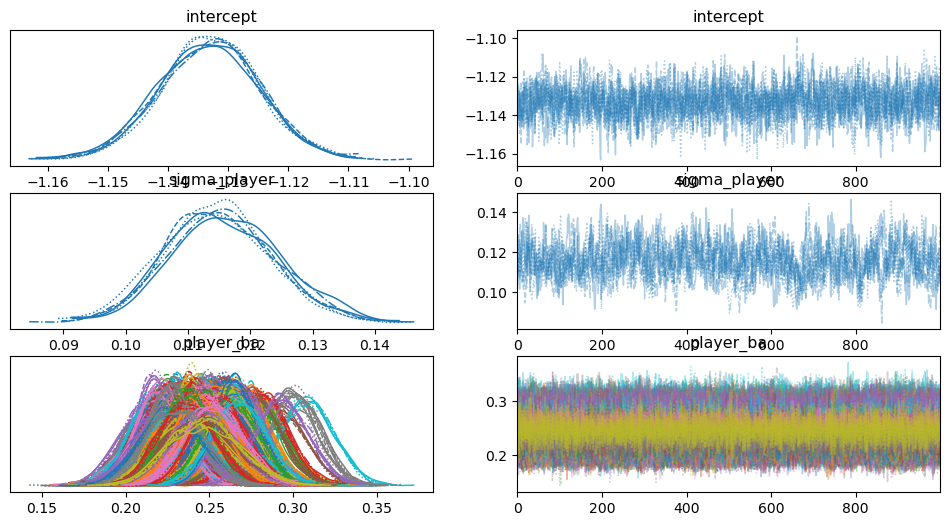

In [171]:
az.plot_trace(idata, var_names=["intercept", "sigma_player", "player_ba"]);

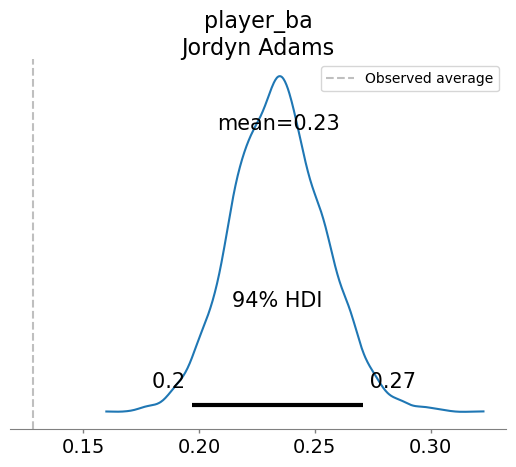

In [172]:
ax = az.plot_posterior(idata, var_names=["player_ba"], coords={"player": ["Jordyn Adams"]});
ax.axvline(x=0.128, color="k", alpha=0.25, linestyle="--", label="Observed average");
ax.legend();

Since the players are exchangeable, the partial pooling that affects Jordyn Adams' batting average comes equally from every other player.

# What if players aren't exchangeable?

Often, the more we learn about our data, the less likely exchangeablity is going to hold.  For example, there's another factor we could incorparate, the `Age` of the player.  What if we think that our hierarchical model of player should be more likely to partially pool information over players that have more similar ages?  **We can use a Gaussian process to accomplish this.**

To see how we can get there, let's rewrite our model but use a multivariate normal with a diagonal covariance matrix, instead of a vector of IID normals.

In [188]:
ix_player, player = pd.factorize(df.Name, sort=True)

coords = {
    "player": player,
}

with pm.Model(coords=coords) as model:
    intercept = pm.Normal("intercept", mu=0.0, sigma=2.0)
    
    sigma_player = pm.Exponential("sigma_player", scale=1.0)
    player_effect = pm.MvNormal("player_effect", mu=intercept, chol=pt.sqrt(sigma_player) * pt.eye(len(player)))
    
    logit_p = player_effect[ix_player]
    pm.Binomial("hits", logit_p=logit_p, n=df.AB.values, observed=df.H.values)

    pm.Deterministic("player_ba", pm.math.sigmoid(player_effect), dims="player")

In [189]:
idata = nutpie.sample(
    nutpie.compile_pymc_model(model, backend="jax"),
    target_accept=0.8,
)

Progress,Draws,Divergences,Step Size,Gradients/Draw
,1300,0,0.32,15
,1300,0,0.31,15
,1300,0,0.31,15
,1300,0,0.30,15
,1300,0,0.30,15
,1300,0,0.30,15


This is the exact same model we had before, except it's parameterized using a multivariate normal with a diagonal covariance matrix.  Even though it samples quite a bit slower, we did this to make it explicit that there's no covariances between players _induced by our prior_.  If there were, we'd have off-diagonal elements that weren't zero.  

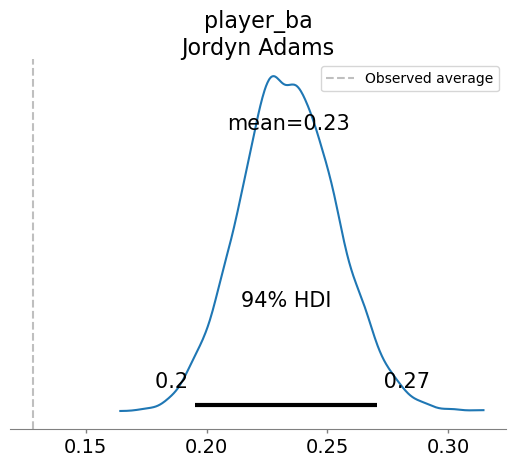

In [191]:
ax = az.plot_posterior(idata, var_names=["player_ba"], coords={"player": ["Jordyn Adams"]});
ax.axvline(x=0.128, color="k", alpha=0.25, linestyle="--", label="Observed average");
ax.legend();

How would we build a prior that incorprates the players age then?  Instead of using a fixed, diagonal covariance matrix, we can use a covariance _function_, or kernel.  It should take two different `age`s as an input, and return a larger value (covariance) if the ages are similar, and a small value if they are pretty different.  The "exponentiated quadratic" is one such covariance that has a particularly simple form:
$$
k(x, x') = \eta^2 \mathrm{exp}\left[ -\frac{(x - x')^2}{2 \ell^2} \right] \,,
$$
where $x$ is age.  There are two unknown parameters, $\eta$ and $\ell$.  $\eta$ plays the exact same role as $\sigma$ does in our normal hierarchical model.  It scales the overall size of the effect, which is the total amount of partial pooling.  The parameter $\ell$ is brand new.  It's called the _lengthscale_.  It determines what we mean by "close", when we say one age is close to another.  

In our baseball example, age is measured in years, so close might be $\ell = 1$ year.  If $\ell = 10$, that means that "10" is more the scale that we think ages are similar.  Note that we should be able to set a pretty informative prior on the lengthscale.  Clearly $\ell=0.1$ is too small.  Players batting average is not likely to change significantly if they get one month older.  Also, $\ell = 100$ is unlikely since that's more on the overall scale of a humans lifespan, not just their baseball skills.  Since the lengthscale is so interpretable we'll often be able to set fairly informative priors.


## An example

Here's what the covariance matrix looks like if we have an x that represents ages, and a lengthscale equal to 1.5, which is a value that's on the same scale as people's ages.

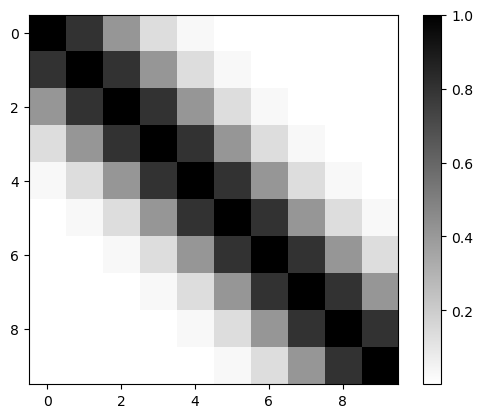

In [17]:
x = np.arange(20, 30)
eta = 1.0
lengthscale = 1.5
cov_func = eta**2 * pm.gp.cov.ExpQuad(1, ls=lengthscale)
K = cov_func(x[:, None]).eval()

plt.imshow(K, cmap="gray_r"); plt.colorbar();

When we order our $x$ sequentially, we see a nice band pattern in the resulting covariance matrix.  The band pattern comes from the fact that our covariance function is giving pairs of ages that are nearby a high covariance. Each cell in the matrix is comparing one age to another, so every combination of pairs is calculated.  **A high covariance value means that if that pair of $x$'s are similar, that means that the values of the GP will be similar there too.**

# So, what is a GP?

Now that we have our covariance function, we can define our GP $f$ as:
$$
f \sim \mathcal{GP}\left( 0 \,, k(x, x') \right)
$$
It's like a multivariate normal, except that the covariance isn't a _matrix_.  It's a _function_.  That means that the overall size or dimension of the multivariate normal is subject to what we decide to plug into that function.  For example, if we have three players with three different ages: 24, 25, and 26 and we plug those in, we get a 3 dimensional multiviariate normal with a $3 \times 3$ covariance matrix.  If we plug in 10 players, it'll be 10 dimensional.  If we plug in 100, it'll be 100 dimensional, and so on. 

**At a basic level, that's really all there is to it.**  If you've tried to learn about GPs before, you'll know that things get more complicated.  This happens down two directions:
1. The covariance function.  We can represent very interesting structures using the covariance function, from random walks to complex periodic behavior, covariances that match up with neural networks, and any aggregation or combinations of these (and many more).
2. Computation. Naively implemented, **GPs are slow**.  They scale $\mathcal{O}(n^3)$, where $n$ is the dimension of the multivariate normal you need to compute the probabilities of.  There are lots of different approximations and computational tricks to improve this scaling.  A lot of GP research focuses here. 

At the end of the day though, a GP is a GP is a GP.  However, there are different kernels, approximations, and methods to accellerate computation.

# Taking a step back

Before we dive into baseball modeling, it's important to take a step back and use some simulated data to start thinking about limiting cases.  Understanding these is critical to debugging GPs when modeling goes wrong.  Very often, for me and for others I've worked with, you'll fit fit a GP model and immediately something will go wrong and it wont sample properly.  It's pretty much inevitable.  If it's not way to slow, then maybe the chains didn't converge or there were diverging samples.  Or, the results were just too unexpected to be believeable.  I think this causes GPs to unfairly get a bad rap, or lead to dissappointment.  In most other resources, the theory behind GPs is explained, then maybe a working example is given, but after that you're on your own. 

My goal in this presentation is give a bit of help on how to diagnose and fix issues -- from the perspective of someone whos fit many broken GP models. 

# Limiting cases

The starting place is limiting cases.  Let's look at a one dimensional (think time series, batter age) GP with our simple exponentiated quadratic coviance function.  

## Case 1: The lengthscale $\ell \rightarrow 0$

When the lengthscale goes to zero, the covariance function reduces to the delta function:
$$
\begin{align}
\lim_{\ell\to0} k(x, x') &= \eta^2 \mathrm{exp}\left[ -\frac{(x - x')^2}{2 \ell^2} \right] \\
                         &= \eta^2 \mathrm{exp}\left[-\frac{1}{2} \left(\frac{x - x'}{\ell}\right)^2 \right] \\
                         &= \begin{cases}
                               \eta^2 & \text{if } x = x' \\
                               0 & \text{otherwise} \,.
                            \end{cases} \\
\end{align}
$$
Which you might recognize produces the identity matrix.  This comes out to be exactly the same as when we using the multivariate normal in the the batting average example.  We can also show in code where you can see it turns out to be the identity matrix.

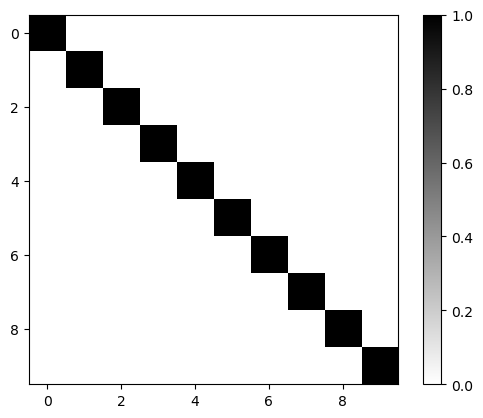

In [59]:
x = np.arange(10)
eta = 1.0
lengthscale = 0.000001 # lengthscale is small relative to the spacing of the x's
cov_func = eta**2 * pm.gp.cov.ExpQuad(1, ls=lengthscale)
K = cov_func(x[:, None]).eval()

plt.imshow(K, cmap="gray_r"); plt.colorbar();

There are two important points here:

1. **The reason this is important for modeling is because when the lengthscale is small, the GP is _equivalent_ to a normal hierarchical model.**
2. **If the lengthscale is smaller than the resolution of your data, then you won't be able to detect the differences there.** For example, it's impossible to detect daily relationships in baseball players age effect, if the age in the data is specified as a year only.

In particular, point 2 can produce an identifiability issue, which will slow sampling and make it less likely that the MCMC chains will converge.  We can see this in the sketch below:

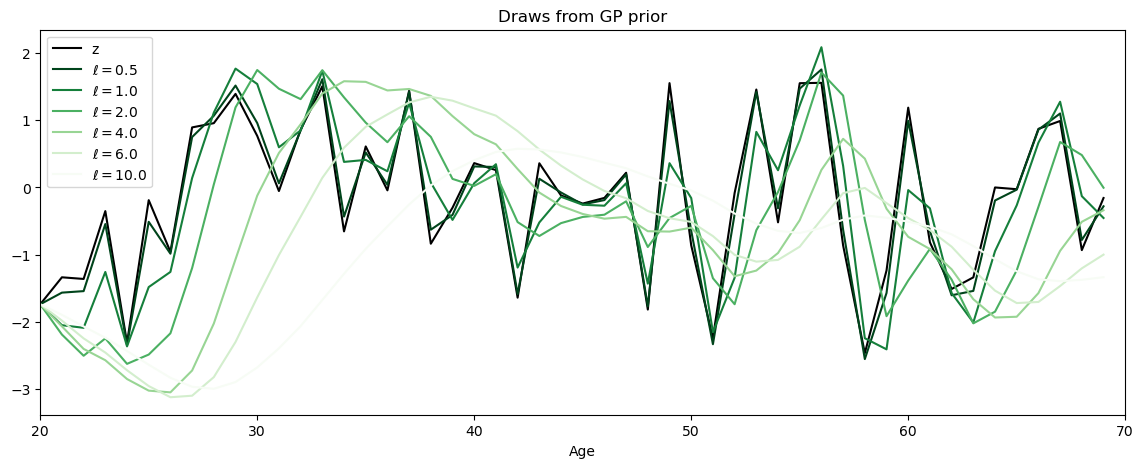

In [86]:
RANDOM_SEED = 8
rng = np.random.default_rng(RANDOM_SEED)

n = 50 # number of days of ages
x = np.arange(20, 20 + n)

lengthscales = [0.5, 1.0, 2.0, 4.0, 6.0, 10.0]
colors = np.linspace(0, 1, len(lengthscales))

fig, ax = plt.subplots(1, 1, figsize=(14, 5))

# draw a sample of random noise
z = rng.normal(size=n)

m = ax.plot(x, z, color="k", label="z");

for i, ell in enumerate(lengthscales):
    cov = pm.gp.cov.Matern52(input_dim=1, ls=ell)
    K = cov(x[:, None]).eval()
    L = np.linalg.cholesky(K + 1e-6 * np.eye(n))
    
    f = L @ z
    
    ax.plot(x, f, color=plt.cm.Greens_r(colors[i]), label=f"$\ell={ell}$")

ax.legend(loc="upper left");
ax.set_xlim([20, n + 20]);
ax.set_xlabel("Age");
ax.set_title("Draws from GP prior");

This shows how a random IID sample of normal noise can be "smoothed" by a GP at varying lengthscales.  We can see that it hardly changes when the lengthscale drops below the resolution of the data.

## The fix

We need our lengthscale prior to block small lengthscales, particularly those below the resolution of the data.  As we've seen, a small lenthscale GP and a normal hierarchical term together in model would be unidentifiable.  

Examples of informative priors that limit the amount of mass at small lengthscales are the inverse gamma distribution, the inverse of an exponential distribution, the log-normal, and the penalized complexity (PC) prior.  Samples from these three distributions are shown below:

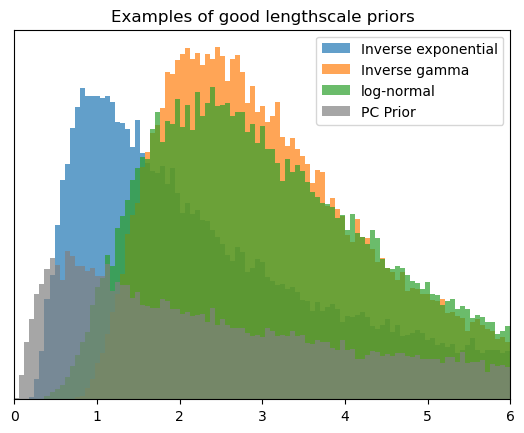

In [87]:
# draw samples from PC prior
alpha_ell, lower_ell = 0.1, 1.0
lam_ell = -np.log(alpha_ell) * np.sqrt(lower_ell)
alpha = 0.5
beta = 1.0 / (lam_ell ** 2)
ell_inv = pm.Weibull.dist(alpha=alpha, beta=beta)
ell = 1 / ell_inv
ell_pc_samples = pm.draw(ell, 50_000)

# inverse gamma
ell = pz.maxent(
    pz.InverseGamma(),
    lower=0.5,
    upper=8.0,
    mass=0.95,
    plot=False,
)
ell = pm.InverseGamma.dist(alpha=ell.alpha, beta=ell.beta)
ell_ig_samples = pm.draw(ell, 50_000)

# lognormal
ell = pz.maxent(
    pz.LogNormal(),
    lower=0.5,
    upper=8.0,
    mass=0.95,
    plot=False,
)
ell = pm.Lognormal.dist(mu=ell.mu, sigma=ell.sigma)
ell_ln_samples = pm.draw(ell, 50_000)

# inverse exponential
ell_inv = pm.Exponential.dist(scale=0.5)
ell = 1 / ell_inv
ell_ie_samples = pm.draw(ell, 50_000)


bins = np.linspace(0, 6, 100)
plt.hist(ell_ie_samples, bins=bins, label="Inverse exponential", alpha=0.7);
plt.hist(ell_ig_samples, bins=bins, label="Inverse gamma", alpha=0.7);
plt.hist(ell_ln_samples, bins=bins, label="log-normal", alpha=0.7);
plt.hist(ell_pc_samples, bins=bins, label="PC Prior", alpha=0.7, color="gray");
plt.xlim([0, 6]);
plt.yticks([])
plt.title("Examples of good lengthscale priors");
plt.legend();

As for what the PC prior _is_, you can read more about it [here](https://arxiv.org/abs/1403.4630), [here](https://arxiv.org/abs/1503.00256) and [here](https://dansblog.netlify.app/posts/2022-08-29-priors4/priors4.html).  The inverse gamma prior recommendation comes from [here](https://betanalpha.github.io/assets/case_studies/gp_part1/part1.html). 

## Case 2: The lengthscale $\ell \rightarrow \infty$

When the lengthscale goes to infitity, the covariance function reduces to a matrix whose entries are all constants:
$$
\begin{align}
\lim_{\ell\to\infty} k(x, x') &= \eta^2 \mathrm{exp}\left[ -\frac{(x - x')^2}{2 \ell^2} \right] \\
                         &= \eta^2 
\end{align}
$$
This is just a matrix where every entry equals $\eta^2$.  This likely looks a litte strange to you, but, it is possible to draw prior samples from this GP:

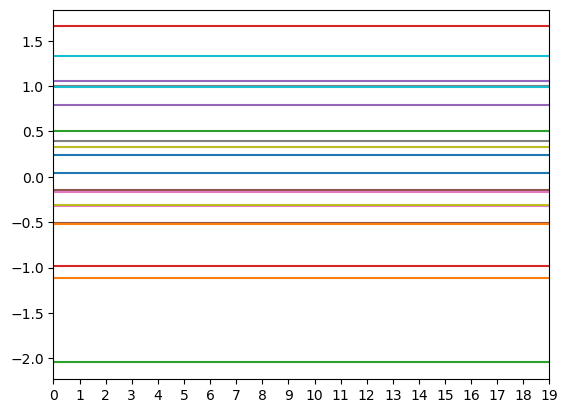

In [94]:
n = 20
s = pm.draw(pm.MvNormal.dist(mu=np.zeros(n), cov=np.ones((n, n))), 20).T
plt.plot(s);
plt.xlim([0, 19]);
plt.xticks(np.arange(20));

**Every sample drawn from this GP is a flat line of varying height.**  This is the same thing as the intercept, which is a term your model probably already has in it.  This means that we potentially hit another identifiability issue again, this time when the lengthscale becomes large.  You can see this in action in the sketch below.  When the lengthscale starts getting into the hundreds, the smoothing looks really flat, and once it's flat it doesn't change.

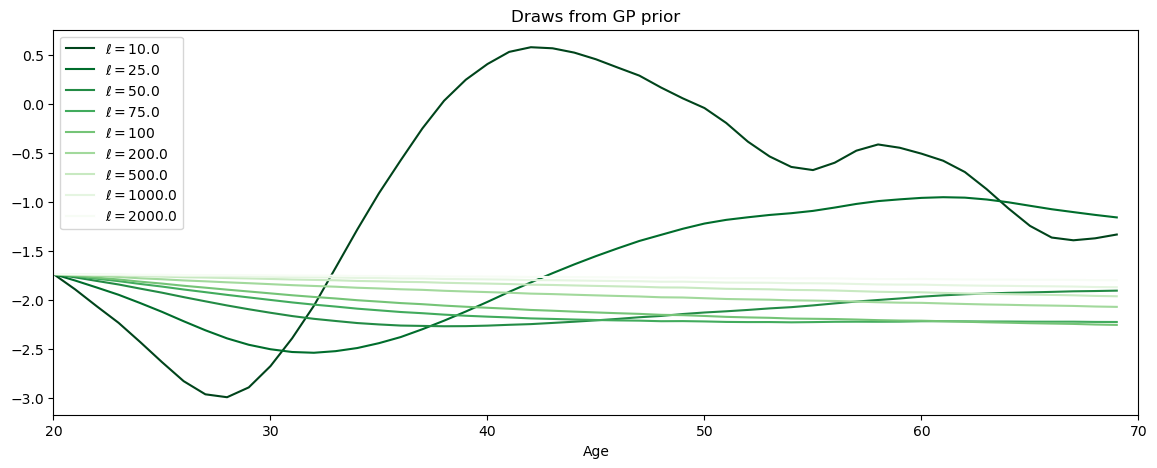

In [98]:
RANDOM_SEED = 8
rng = np.random.default_rng(RANDOM_SEED)

n = 50 # number of days of ages
x = np.arange(20, 20 + n)

lengthscales = [10.0, 25.0, 50.0, 75.0, 100, 200.0, 500.0, 1000.0, 2000.0]
colors = np.linspace(0, 1, len(lengthscales))

fig, ax = plt.subplots(1, 1, figsize=(14, 5))

# draw a sample of random noise
z = rng.normal(size=n)

for i, ell in enumerate(lengthscales):
    cov = pm.gp.cov.Matern52(input_dim=1, ls=ell)
    K = cov(x[:, None]).eval()
    L = np.linalg.cholesky(K + 1e-6 * np.eye(n))
    
    f = L @ z
    
    ax.plot(x, f, color=plt.cm.Greens_r(colors[i]), label=f"$\ell={ell}$")

ax.legend(loc="upper left");
ax.set_xlim([20, n + 20]);
ax.set_xlabel("Age");
ax.set_title("Draws from GP prior");

## The fix

The fix this time is to again, be aware that this is possible.  You could consider:
1. Remove the intercept term from your model.
2. Remove the GP from your model, because if it's trying to be flat, then it's not measuring an effect.
 
In fact, all GPs (of this type with a lengthscale parameter, the Matern family) aren't fixed to have a mean exactly at zero, so there's always a little bit of an identifiability problem with the intercept.  The identifiability problem gets worse as the lengthscale increases.  If you're in a middle ground and it's causing issues, you can additionally consider:

3. Constraining the GP to have mean of zero. How exactly you do that depends on the type of GP you're dealing with.

Finally:

4. Depending on your context,  it may make sense to address this problem by constraining the lengthscale to not be too large.  The inverse gamma is particularly good for this.  This is OK to do when you're **sure** that there is a GP in your model, and you're goal isn't to test whether an effect from the GP is there or not.  If that is your aim, use the PC prior because that's what it was designed for.    

# Back to baseball

- fit SLG
- HSGP 
- Exp vs. Matern


# Identifiability

You may be noticing a pattern here.  There are identifiability problems when the lengthscale is too small or too big.  It may feel like we're getting pretty far away from practical issues here, but please bear with me!  There's also an identifiability issue between the lengthscale $\ell$ and the scale, $\eta$.  This one is inherent to the form of the Matern family of covariance functions.  You can plainly see it when you look at the Fourier transform of the exponentiated quadratic covariance function (via Bochner's theorem).  The result is given below:
$$
\begin{align}
S(s) \propto \eta^2 \ell \exp{\left[ -2\pi\ell^2s^2 \right]}
\end{align}
$$
Here, $S(s)$ is the power spectrum at frequencies $s$ of the kernel.  In the first part, $\eta^2$ and $\ell$ are multiplying each other.  This means that their product is identified, but $\eta$ and $\ell$ individually aren't.  Even though we're in Fourier space, this problem will exist in the non-Fourier space.  Fortunately inside the exponential function we just have the lengthscale parameter.  We can consider $\eta$ and $\ell$ _weakly_ identifiable.  You can read more about it in this note [here](https://drive.google.com/file/d/0B3WHb3BabixAYlptTVBWUGdyVEE/view?resourcekey=0-mj7f4AZQ-UN1Rvd9NrRlHg).  


# What is "N"?

In general, I've seen people describe GPs as "weakly identifiable" as sort of a blanket statement.    

# Choice of covariance function

Use Matern, not ExpQuad.  The posterior mean is always smoother than the posterior samples. 